# Inequality and Polarization: An Agent-Based Modeling Approach Using Eurostat Data

by:
- Kevin Heinrich, 11902941
- Matthias Hemmer, 11804194
- Marina Hofer, 12337819
- Christina Sophie Knes, 11902902

## Project Description

This project explores the relationship between regional income inequality and social polarization in Europe using agent-based modeling. Drawing on real-world data from Eurostat, including the Gini coefficient, at-risk-of-poverty rates and disposable income across NUTS-2 regions, we simulate how economic disparities might influence public opinion dynamics and social fragmentation.

We implement a modified Deffuant model, where agents interact and adjust their opinions based on income differences and local economic context. The model integrates heterogeneity in income, frustration levels, and opinion tolerance, creating a dynamic system that allows us to observe under which conditions polarization emerges.

Our main objectives are:
- To simulate opinion formation in a socioeconomically stratified population.
- To explore how varying levels of inequality and redistribution affect polarization.
- To identify regional vulnerability to polarization based on Eurostat indicators.

Through these simulations, we aim to provide insights into how economic structures may contribute to societal tensions, and how policy interventions might influence collective outcomes.

## Environment Setup

For the following project, **Python Version 3.13.5** was used.


**`TODO: Rewrite import description when everything is ready for submission`**

The following libraries are required for this project:

### Deep Learning
- **`torch`** – PyTorch, an open-source deep learning library for tensor computation and neural networks.

### Natural Language Processing (NLP)
- **`nltk`** – Toolkit for working with human language data, supporting text processing and analysis.
- **`spacy`** – Fast and production-ready NLP library with pre-trained models and support for pipelines.
- **`textstat`** – A package for computing text readability scores and complexity metrics.

### Standard Library Modules
- **`re`** – Provides regular expression matching operations.
- **`os`** – Interfaces for interacting with the operating system.
- **`math`** – Mathematical functions such as logarithms, square roots, and constants.
- **`unicodedata`** – Utilities for Unicode character properties and normalization.


## PIP installations

To install the required libraries, run the following:

In [1]:
! pip install eurostat
! pip install numpy
! pip install pandas
! pip install mesa
! pip install scipy
! pip install matplotlib
! pip install seaborn

## Import modules

In [2]:
import eurostat
from mesa import Model, Agent, DataCollector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

/home/xanixx/Documents/00_UNI/011_CMSS/project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Preprocessing Constants
TARGET_INCOME_UNIT = "EUR" # Unit of measure: Euro
TARGET_INDIC_IL = "MEI_E" # Income and living conditions indicator: Mean equivalised net income
TARGET_AGE = "TOTAL"
TARGET_SEX = "T" # Total

NUM_STEPS = 100
NUM_AGENTS_PER_REGION = 50
SEED = 15
SHIFT_RATE = 0.2
NOISE_STD = 0.05

## Set Seed for "random" calls

In [4]:
np.random.seed(SEED)

## Define and create "results" directory

In [5]:
result_dir = Path.cwd().joinpath("results")
result_dir.mkdir(parents=True, exist_ok=True)

## 1. Read Eurostat data

Firstly, we download the necessary datasets via the `eurostat` API.

In [6]:
df_orig_mean_median_income = eurostat.get_data_df("ilc_di03")
df_orig_gini_coefficient = eurostat.get_data_df("ilc_di12")
df_orig_risk_of_poverty = eurostat.get_data_df("ilc_li02")
df_orig_household_cost_shares = eurostat.get_data_df("ilc_mded01")
df_orig_unemployment_rate = eurostat.get_data_df("une_rt_a")

## 2. Preprocess data

In [7]:
relevant_years = [str(year) for year in range(2015, 2025)] 
relevant_columns = ["geo"] + relevant_years

### 2.1 Preprocess "Mean and Median income" Dataset

In [8]:
df_processed_mean_median_income = df_orig_mean_median_income.copy(deep=True)

df_processed_mean_median_income = df_processed_mean_median_income.rename(columns={"geo\\TIME_PERIOD": "geo"})
df_processed_mean_median_income = df_processed_mean_median_income[(df_processed_mean_median_income["sex"] == TARGET_SEX) & 
                                                                  (df_processed_mean_median_income["age"] == TARGET_AGE) &
                                                                  (df_processed_mean_median_income["unit"] == TARGET_INCOME_UNIT) &
                                                                  (df_processed_mean_median_income["indic_il"] == TARGET_INDIC_IL)]
df_processed_mean_median_income = df_processed_mean_median_income[relevant_columns]
df_processed_mean_median_income = df_processed_mean_median_income.dropna()

### 2.2 Preprocess "Gini Coefficient" Dataset

In [9]:
df_processed_gini_coefficient = df_orig_gini_coefficient.copy(deep=True)

df_processed_gini_coefficient = df_processed_gini_coefficient.rename(columns={"geo\\TIME_PERIOD": "geo"})
df_processed_gini_coefficient = df_processed_gini_coefficient[df_processed_gini_coefficient["age"] == TARGET_AGE]
df_processed_gini_coefficient = df_processed_gini_coefficient[relevant_columns]
df_processed_gini_coefficient = df_processed_gini_coefficient.dropna()

# Convert the percentage value in a floating point number for every gini coefficient
for year in relevant_years:
    df_processed_gini_coefficient[year] = df_processed_gini_coefficient[year].div(100).round(4)

### 2.3 Preprocess "At-risk-of-poverty" Dataset

In [10]:
df_processed_risk_of_poverty = df_orig_risk_of_poverty.copy(deep=True)

df_processed_risk_of_poverty = df_processed_risk_of_poverty.rename(columns={"geo\\TIME_PERIOD": "geo"})
df_processed_risk_of_poverty = df_processed_risk_of_poverty[(df_processed_risk_of_poverty["sex"] == TARGET_SEX) & 
                                                            (df_processed_risk_of_poverty["age"] == TARGET_AGE) &
                                                            (df_processed_risk_of_poverty["indic_il"] == "LI_R_M60") &
                                                            (df_processed_risk_of_poverty["unit"] == "PC")]
df_processed_risk_of_poverty = df_processed_risk_of_poverty[relevant_columns]
df_processed_risk_of_poverty = df_processed_risk_of_poverty.dropna()

for year in relevant_years:
    df_processed_risk_of_poverty[year] = df_processed_risk_of_poverty[year].div(100).round(4)

### 2.4 Preprocess "Housing Cost" Dataset

In [11]:
df_processed_household_cost_shares = df_orig_household_cost_shares.copy(deep=True)

df_processed_household_cost_shares = df_processed_household_cost_shares.rename(columns={"geo\\TIME_PERIOD": "geo"})
df_processed_household_cost_shares = df_processed_household_cost_shares[(df_processed_household_cost_shares["incgrp"] == "TOTAL") & 
                                                            (df_processed_household_cost_shares["hhtyp"] == "TOTAL")]
df_processed_household_cost_shares = df_processed_household_cost_shares[relevant_columns]
df_processed_household_cost_shares = df_processed_household_cost_shares.dropna()

for year in relevant_years:
    df_processed_household_cost_shares[year] = df_processed_household_cost_shares[year].div(100).round(4)

### 2.5 Preprocess "Inflation" Dataset

In [12]:
df_unemployment_rate = df_orig_unemployment_rate.copy(deep=True)

df_unemployment_rate = df_unemployment_rate.rename(columns={"geo\\TIME_PERIOD": "geo"})
df_unemployment_rate = df_unemployment_rate[(df_unemployment_rate["age"] == "Y15-74") & (df_unemployment_rate["sex"] == "T")
                                            & (df_unemployment_rate["unit"] == "PC_POP")]
df_unemployment_rate = df_unemployment_rate[relevant_columns]
df_unemployment_rate = df_unemployment_rate.dropna()
for year in relevant_years:
    df_unemployment_rate[year] = df_unemployment_rate[year].div(100).round(4)

### 2.6 Calculate intersection of regions between all datasets


In [13]:
distinct_regions_mean_median_income = set(df_processed_mean_median_income["geo"].unique())
distinct_regions_gini_coefficient = set(df_processed_gini_coefficient["geo"].unique())
distinct_regions_risk_of_poverty = set(df_processed_risk_of_poverty["geo"].unique())
distinct_regions_household_cost_shares = set(df_processed_household_cost_shares["geo"].unique())
distinct_unemployment_rate = set(df_unemployment_rate["geo"].unique())

shared_regions = distinct_regions_mean_median_income & distinct_regions_gini_coefficient & distinct_regions_household_cost_shares & distinct_regions_risk_of_poverty & distinct_unemployment_rate

df_processed_mean_median_income = df_processed_mean_median_income[df_processed_mean_median_income["geo"].isin(shared_regions)].copy()
df_processed_gini_coefficient = df_processed_gini_coefficient[df_processed_gini_coefficient["geo"].isin(shared_regions)].copy()
df_processed_risk_of_poverty = df_processed_risk_of_poverty[df_processed_risk_of_poverty["geo"].isin(shared_regions)].copy()
df_processed_household_cost_shares = df_processed_household_cost_shares[df_processed_household_cost_shares["geo"].isin(shared_regions)].copy()
df_unemployment_rate = df_unemployment_rate[df_unemployment_rate["geo"].isin(shared_regions)].copy()

## 3. Generate Synthetic Income Distribution

In [14]:
# See: https://en.wikipedia.org/wiki/Log-normal_distribution
def generate_synthetic_income_distribution(avg_income: float, gini: float, n: int = NUM_AGENTS_PER_REGION):
    sigma = gini * 1.5  # empirical tuning
    mu = np.log(avg_income) - (sigma ** 2) / 2
    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

In [15]:
income_distributions = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    df_merged = mean_incomes.merge(gini_coefficients, left_on="geo", right_on="geo")
    
    distributions_by_year = {}
    for _, row in df_merged.iterrows():
        region = row["geo"]
        mean_income = row["mean"]
        gini = row["gini"]
        distributions_by_year[region] = generate_synthetic_income_distribution(mean_income, gini)
    
    income_distributions[year] = distributions_by_year

## 4. Create the Agent and Model Classes

In [ ]:
class PersonAgent(Agent):
    def __init__(self,
                model,
                region: str,
                income: float,
                gini: float,
                opinion: float,
                household_cost_share: float | None,
                unemployment_rate: float,
                poverty_flag: bool = False,
                ):
        super().__init__(model)
        self.region = region
        self.income = income
        self.gini = gini
        self.opinion = opinion
        self.effective_income = income
        if household_cost_share is not None:
            self.effective_income = income * (1 - household_cost_share)
        self.poverty_flag = poverty_flag
        self.unemployment_rate = unemployment_rate

        # Frustration increases if income is below region average or in poverty
        region_avg = self.model.region_data[self.model.region_data["geo"] == region]["mean"].values[0]
        self.frustration = float(max(0, (region_avg - self.effective_income) / region_avg))
        self.frustration = float(min(1, self.frustration + self.unemployment_rate  * 0.5))
        if self.poverty_flag:
            self.frustration = float(min(1, self.frustration + 0.2))  # amplify if in poverty

        # Tolerance: more frustration → less tolerance
        self.tolerance = min(0.5, 0.1 * self.frustration)
    
    
    def step(self):
        partner: PersonAgent = self.random.choice(self.model.agents)
        delta = abs(self.opinion - partner.opinion)
        
        noise1 = self.random.gauss(0, NOISE_STD)
        noise2 = self.random.gauss(0, NOISE_STD)
        
        if delta < self.tolerance and delta < partner.tolerance:
            mu = self.model.mu
            opinion1, opinion2 = self.opinion, partner.opinion
            self.opinion += mu * (opinion2- opinion1) + noise1
            partner.opinion += mu * (opinion1 - opinion2) + noise2
            # Ensure to stay in a valid range
            self.opinion = min(max(self.opinion, 0), 1)
            partner.opinion = min(max(partner.opinion, 0), 1)

In [20]:
class InequalityModel(Model):
    def __init__(self, region_data: pd.DataFrame, synthetic_incomes: dict[str, list[float]], agents_per_region: int, mu: float):
        super().__init__(seed=SEED)
        self.mu = mu
        self.region_data = region_data

        self.init_agents(region_data, synthetic_incomes, agents_per_region)

        self.datacollector = DataCollector(
            model_reporters={
                "OpinionVariance": lambda m: np.var([a.opinion for a in m._agents]).round(4),
                "OpinionMean": lambda m: np.mean([a.opinion for a in m._agents]).round(4),
                "FrustrationVariance": lambda m: np.var([a.frustration for a in m._agents]).round(4),
                "FrustrationMean": lambda m: np.mean([a.frustration for a in m._agents]).round(4)
            },
            agent_reporters={
                "Opinion": "opinion",
                "Region": "region",
                "Frustration": "frustration"
            }
        )


    def init_agents(self, region_data: pd.DataFrame, synthetic_incomes: dict[str, list[float]], agents_per_region: int):
        for _, row in region_data.iterrows():
            region = row['geo']
            gini = row['gini']
            household_cost_share = row["household_cost_share"] if "household_cost_share" in row.index else None
            poverty_rate = row["at_risk_of_poverty"]
            unemployment_rate = row["unemployment_rate"]

            for i in range(agents_per_region):
                income = synthetic_incomes[region][i]
                opinion = np.random.uniform(0, 1)
                poverty_flag = np.random.rand() < poverty_rate
                
                PersonAgent(self, region, income, gini, opinion, household_cost_share, poverty_flag, unemployment_rate)
                

    def run_simulation(self, number_of_steps: int) -> tuple[pd.DataFrame, pd.DataFrame]:
        for _ in range(number_of_steps):
            self.agents.do("step")
        self.datacollector.collect(self)
        model_df = self.datacollector.get_model_vars_dataframe()
        agent_df = self.datacollector.get_agent_vars_dataframe()
        
        return model_df, agent_df

## 5. Run model

In [21]:
mean_frustrations_over_years = {}
mean_opinions_over_years = {}
for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    at_risk_of_poverty = df_processed_household_cost_shares[["geo", year]].rename(columns={year: "at_risk_of_poverty"})
    household_costs = df_processed_household_cost_shares[["geo", year]].rename(columns={year: "household_cost_share"})
    unemployment_rate = df_unemployment_rate[["geo", year]].rename(columns={year: "unemployment_rate"})
    df_region_data = mean_incomes.merge(gini_coefficients, left_on="geo", right_on="geo")
    df_region_data = df_region_data.merge(at_risk_of_poverty, left_on="geo", right_on="geo")
    df_region_data = df_region_data.merge(household_costs, left_on="geo", right_on="geo")
    df_region_data = df_region_data.merge(unemployment_rate, left_on="geo", right_on="geo")

    model = InequalityModel(region_data=df_region_data, synthetic_incomes=income_distributions[year], agents_per_region=NUM_AGENTS_PER_REGION, mu=SHIFT_RATE)
    model_df, agent_df = model.run_simulation(NUM_STEPS)
    
    mean_frustrations_over_years[year] = model_df["FrustrationMean"].values[0]
    mean_opinions_over_years[year] = model_df["OpinionMean"].values[0]

## 6. Plot mean frustrations over years

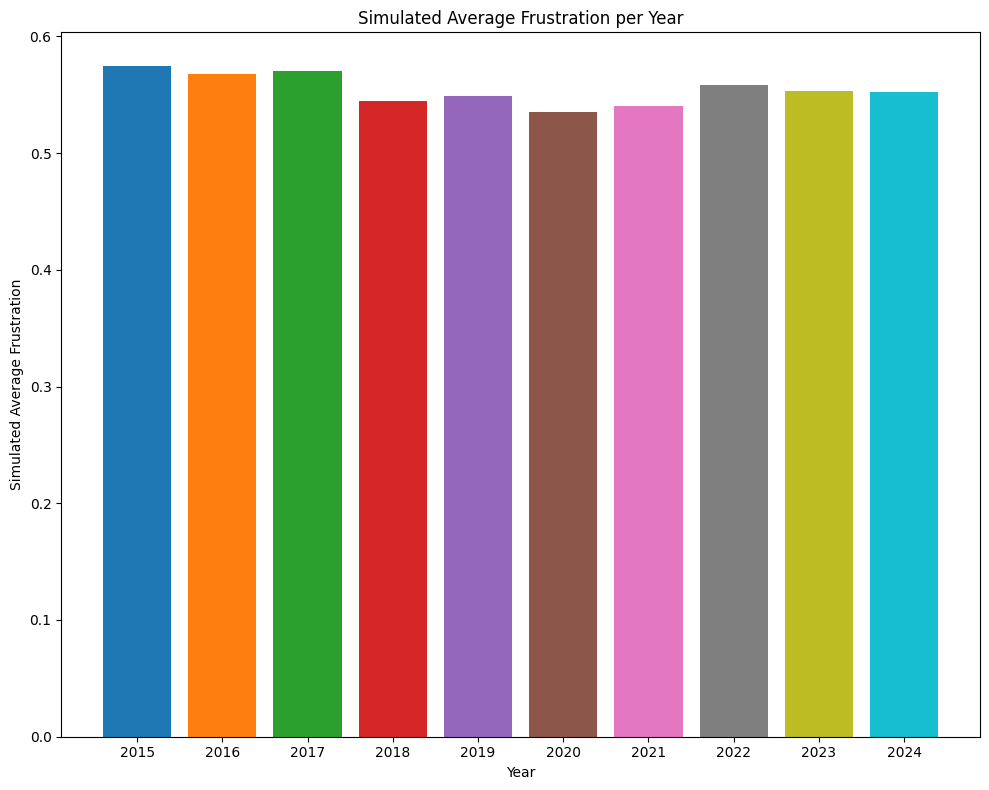

In [22]:
years = list(mean_frustrations_over_years.keys())
frustration_means = list(mean_frustrations_over_years.values())

palette = sns.color_palette("tab10", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year")
plt.ylabel("Simulated Average Frustration")
plt.title("Simulated Average Frustration per Year")
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_frustrations_over_years.pdf"), format="pdf")
plt.show()

## 7. Plot mean opinions over years

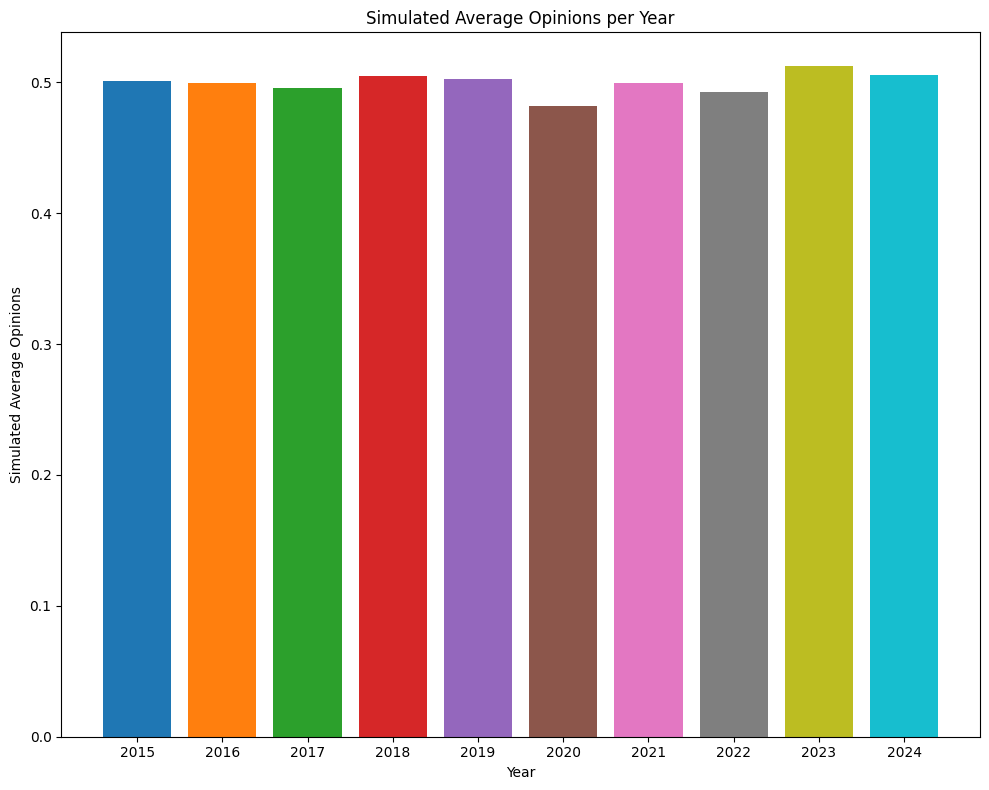

In [23]:
years = list(mean_opinions_over_years.keys())
frustration_means = list(mean_opinions_over_years.values())

palette = sns.color_palette("tab10", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year")
plt.ylabel("Simulated Average Opinions")
plt.title("Simulated Average Opinions per Year")
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_opinions_over_years.pdf"), format="pdf")
plt.show()